In [1]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
from IPython.display import display
from PIL import Image
from math import exp

## Simulate the systme with PINN

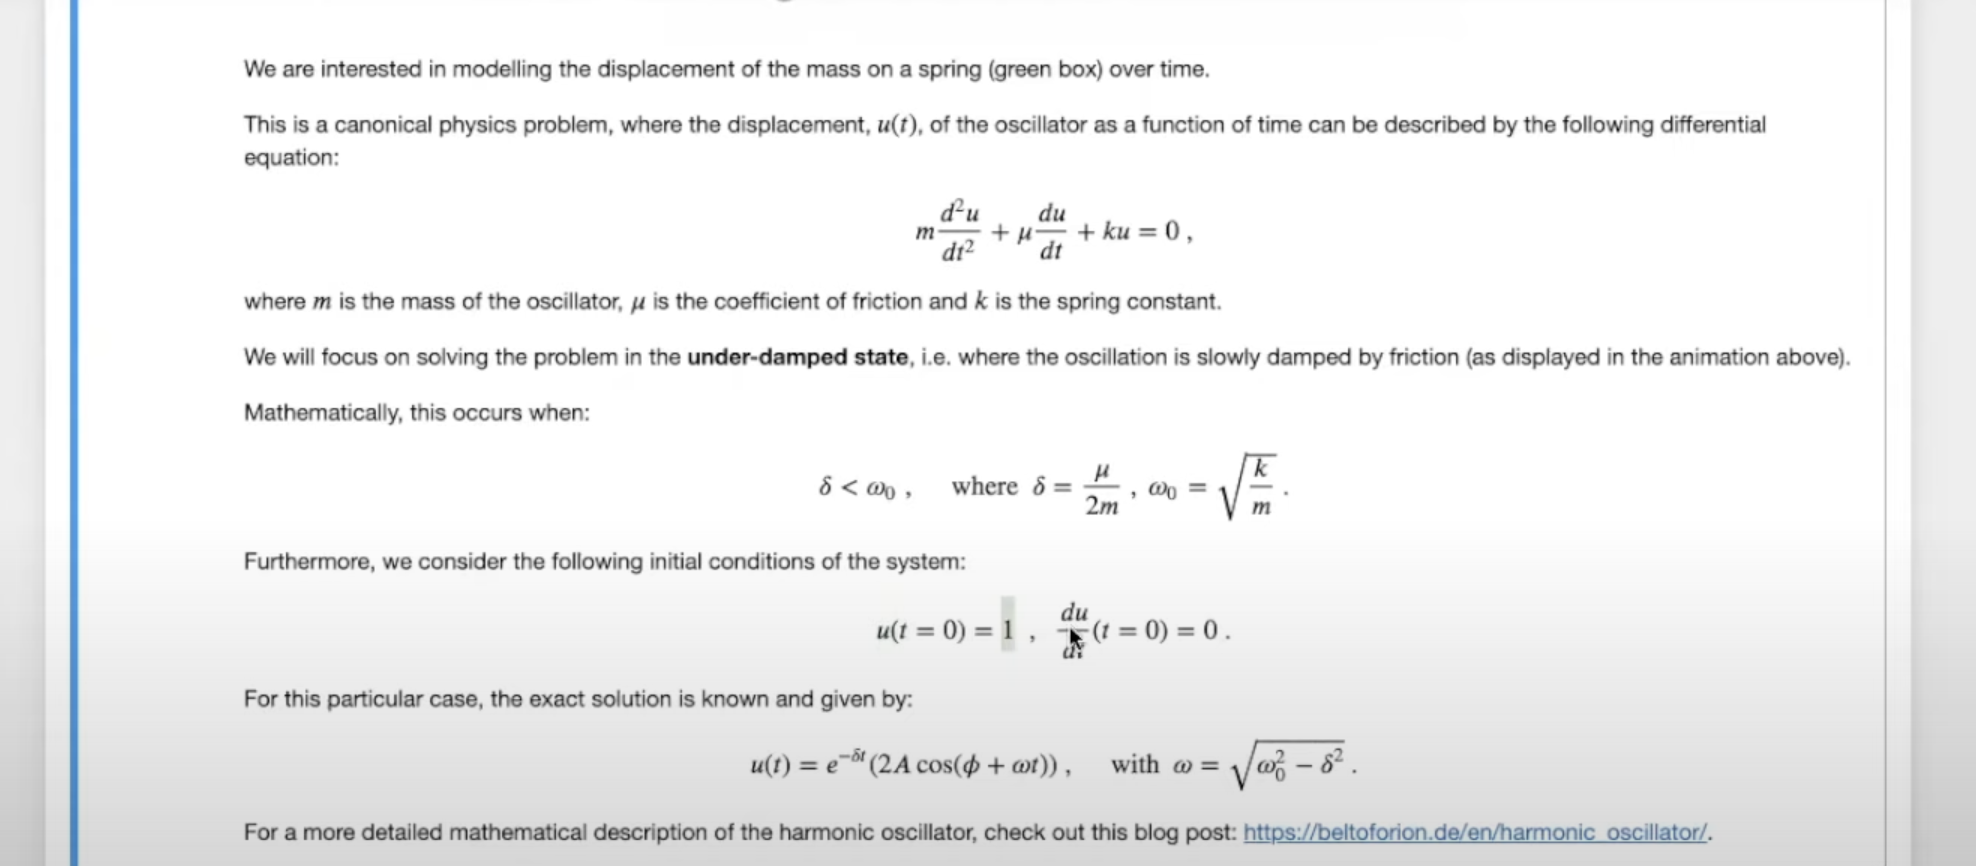

In [2]:
# Load the image
image_path = '/Users/krushna/Desktop/Screenshot 2024-03-27 at 2.32.06 PM.png'  # Provide the path to your image file
image = Image.open(image_path)

# Display the image
display(image)

## Helper Function 

In [3]:
def excat_solution(d,wo,t):
    assert d < wo
    # w = (wo^2 - d^2 )^1/2
    w = np.sqrt(wo**2-d**2)
    
    # -theta*t
    phi = np.arctan(-d/w)
    
    # A (in the above equation)
    A = 1/(2*np.cos(phi))
    
    # cos = (phi + wt)
    cos = torch.cos(phi+w*t)
    
    # exponent
    exp = torch.exp(-d*t)
    # combining all 
    u = exp*2*A*cos
    
    return u

class FCN(nn.Module):
    def __init__(self, ninput,noutput, nhidden, nlayers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential (* [
                       nn.Linear(ninput,nhidden), activation() ])
        
        self.fch = nn.Sequential (* [
                       nn.Sequential(* [
                           nn.Linear(nhidden, nhidden), activation() ]) for _ in range(nlayers-1)])
        self.fce = nn.Linear(nhidden, noutput)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
        
        

## Train a PINN Simulate System

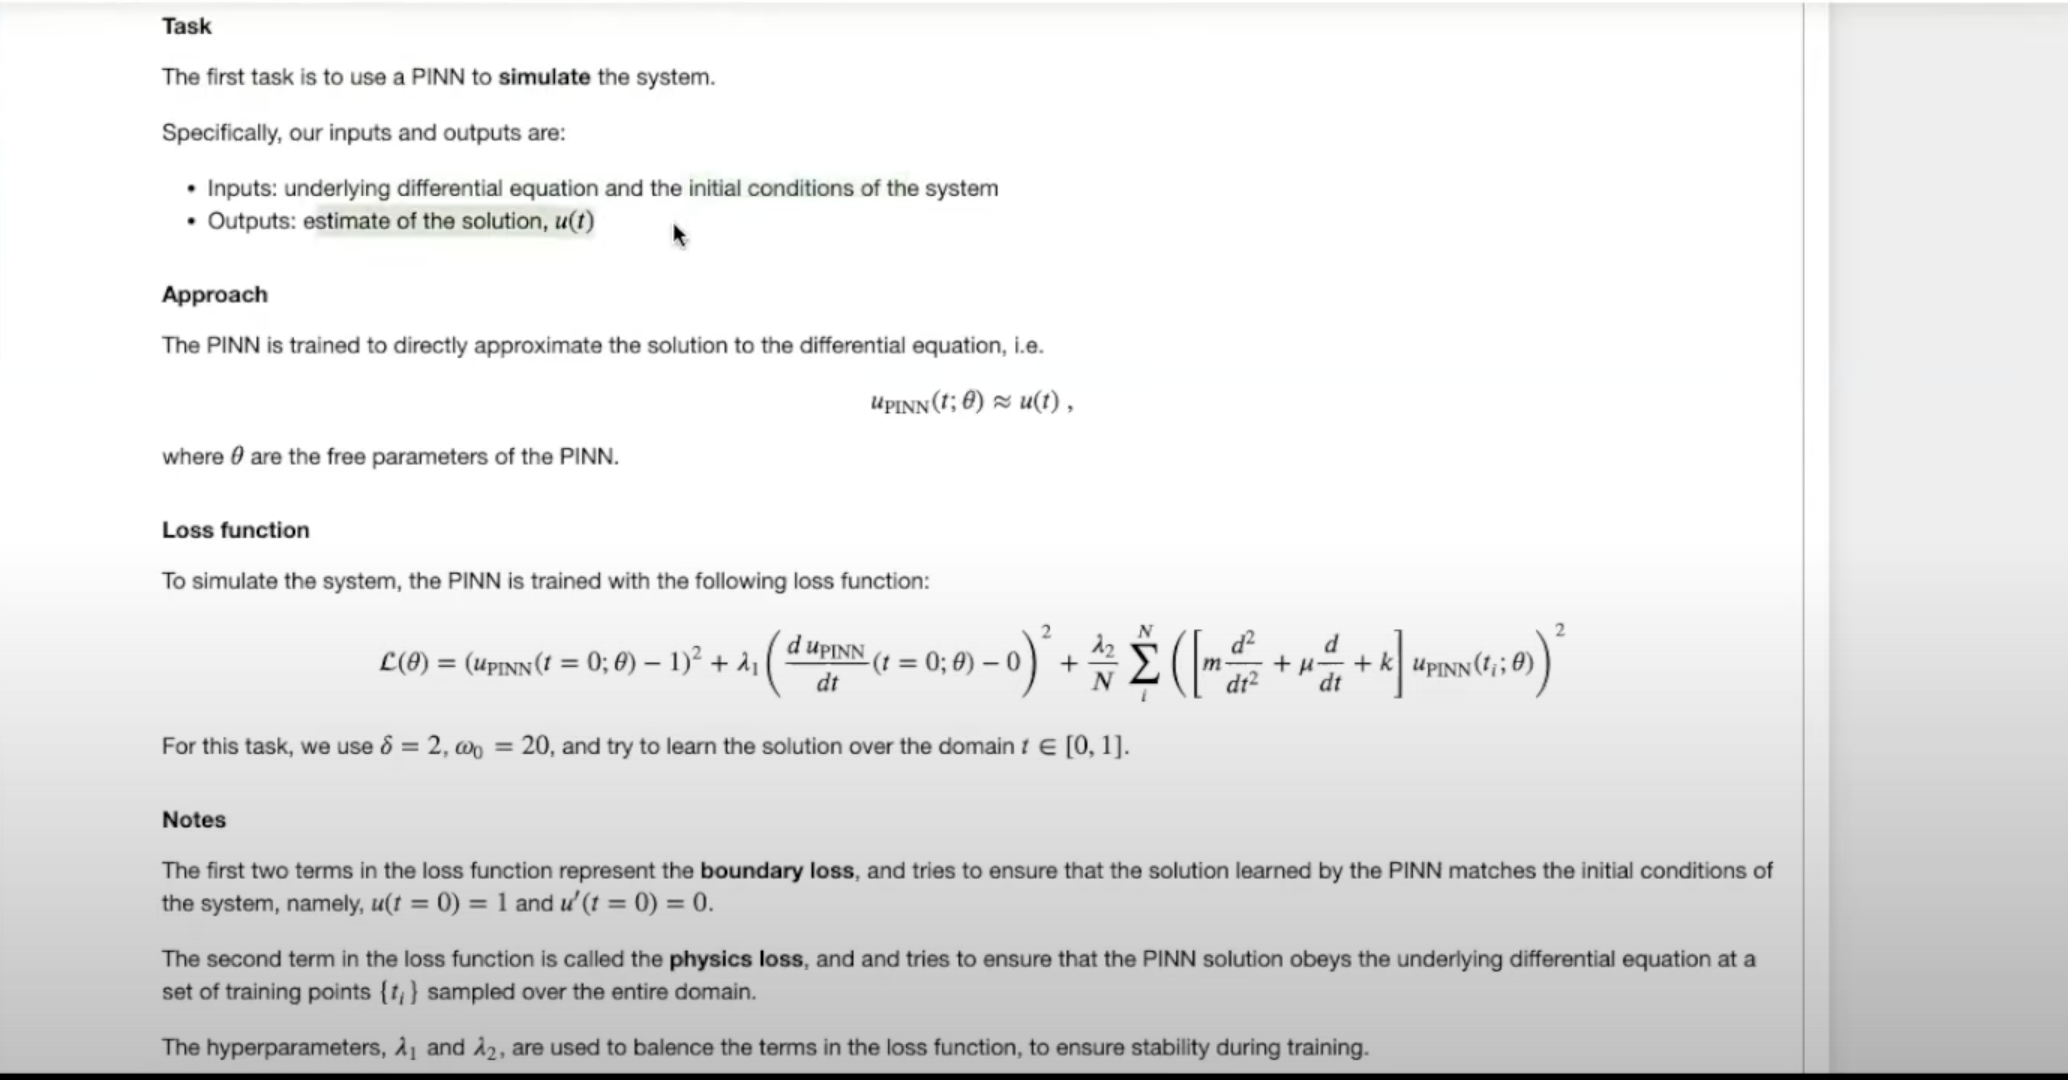

In [4]:
# Load the image
image_path = '/Users/krushna/Desktop/Screenshot 2024-03-27 at 3.11.19 PM.png'  # Provide the path to your image file
image = Image.open(image_path)

# Display the image
display(image)

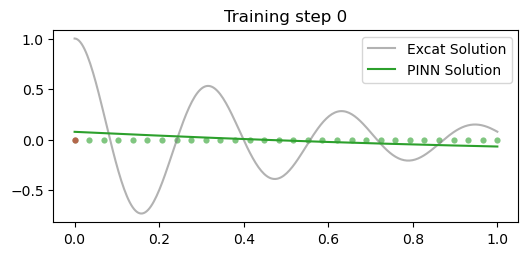

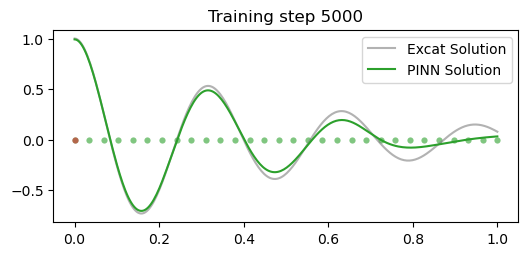

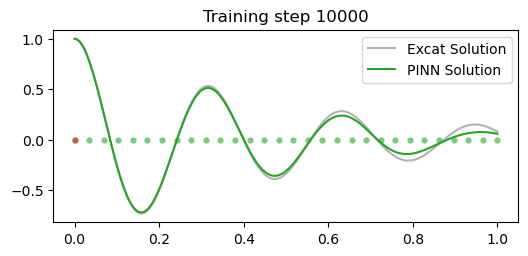

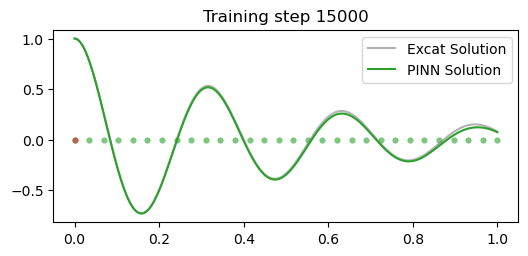

In [5]:
torch.manual_seed(123)

# define neural network to train the model
pinn = FCN(1,1,32,3)
    
# define boundry points for the boundry loss
t_boundry = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define physical loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the pinn
d , wo= 2,20
mu,k = 2*d , wo**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = excat_solution(d,wo,t_test)
optimiser = torch.optim.Adam(pinn.parameters() , lr = 1e-3)

for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the Pinn loss function using hyperparameters
    lambda1, lambda2 = 1e-1, 1e-4
    
    #compute boundries loss
    u = pinn(t_boundry)
    loss1 = (torch.squeeze(u) -1)**2
    
    dudt = torch.autograd.grad(u,t_boundry,torch.ones_like(u) , create_graph = True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    #compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u,t_physics,torch.ones_like(u) , create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt,t_physics,torch.ones_like(u) , create_graph = True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    
    
    #backpropogate joint loss, take optimiser step
    loss = loss1+lambda1*loss2+lambda2*loss3
    loss.backward()
    optimiser.step()
    
    if i %5000 ==0:
        #print(u.abs().mean().item(), dudt.abs().mean().item , d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize = (6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                   torch.zeros_like(t_physics)[:,0],s = 20, lw = 0 , color = "tab:green", alpha = 0.6)
        plt.scatter(t_boundry.detach()[:,0],
                   torch.zeros_like(t_boundry)[:,0],s = 20, lw = 0 , color = "tab:red", alpha = 0.6)
        plt.plot(t_test[:,0] , u_exact[:,0], label = "Excat Solution", color = "tab:grey", alpha =0.6)
        plt.plot(t_test[:,0] , u[:,0], label = "PINN Solution", color = "tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
              

## -2 Train PINN to invert for underlying parameters

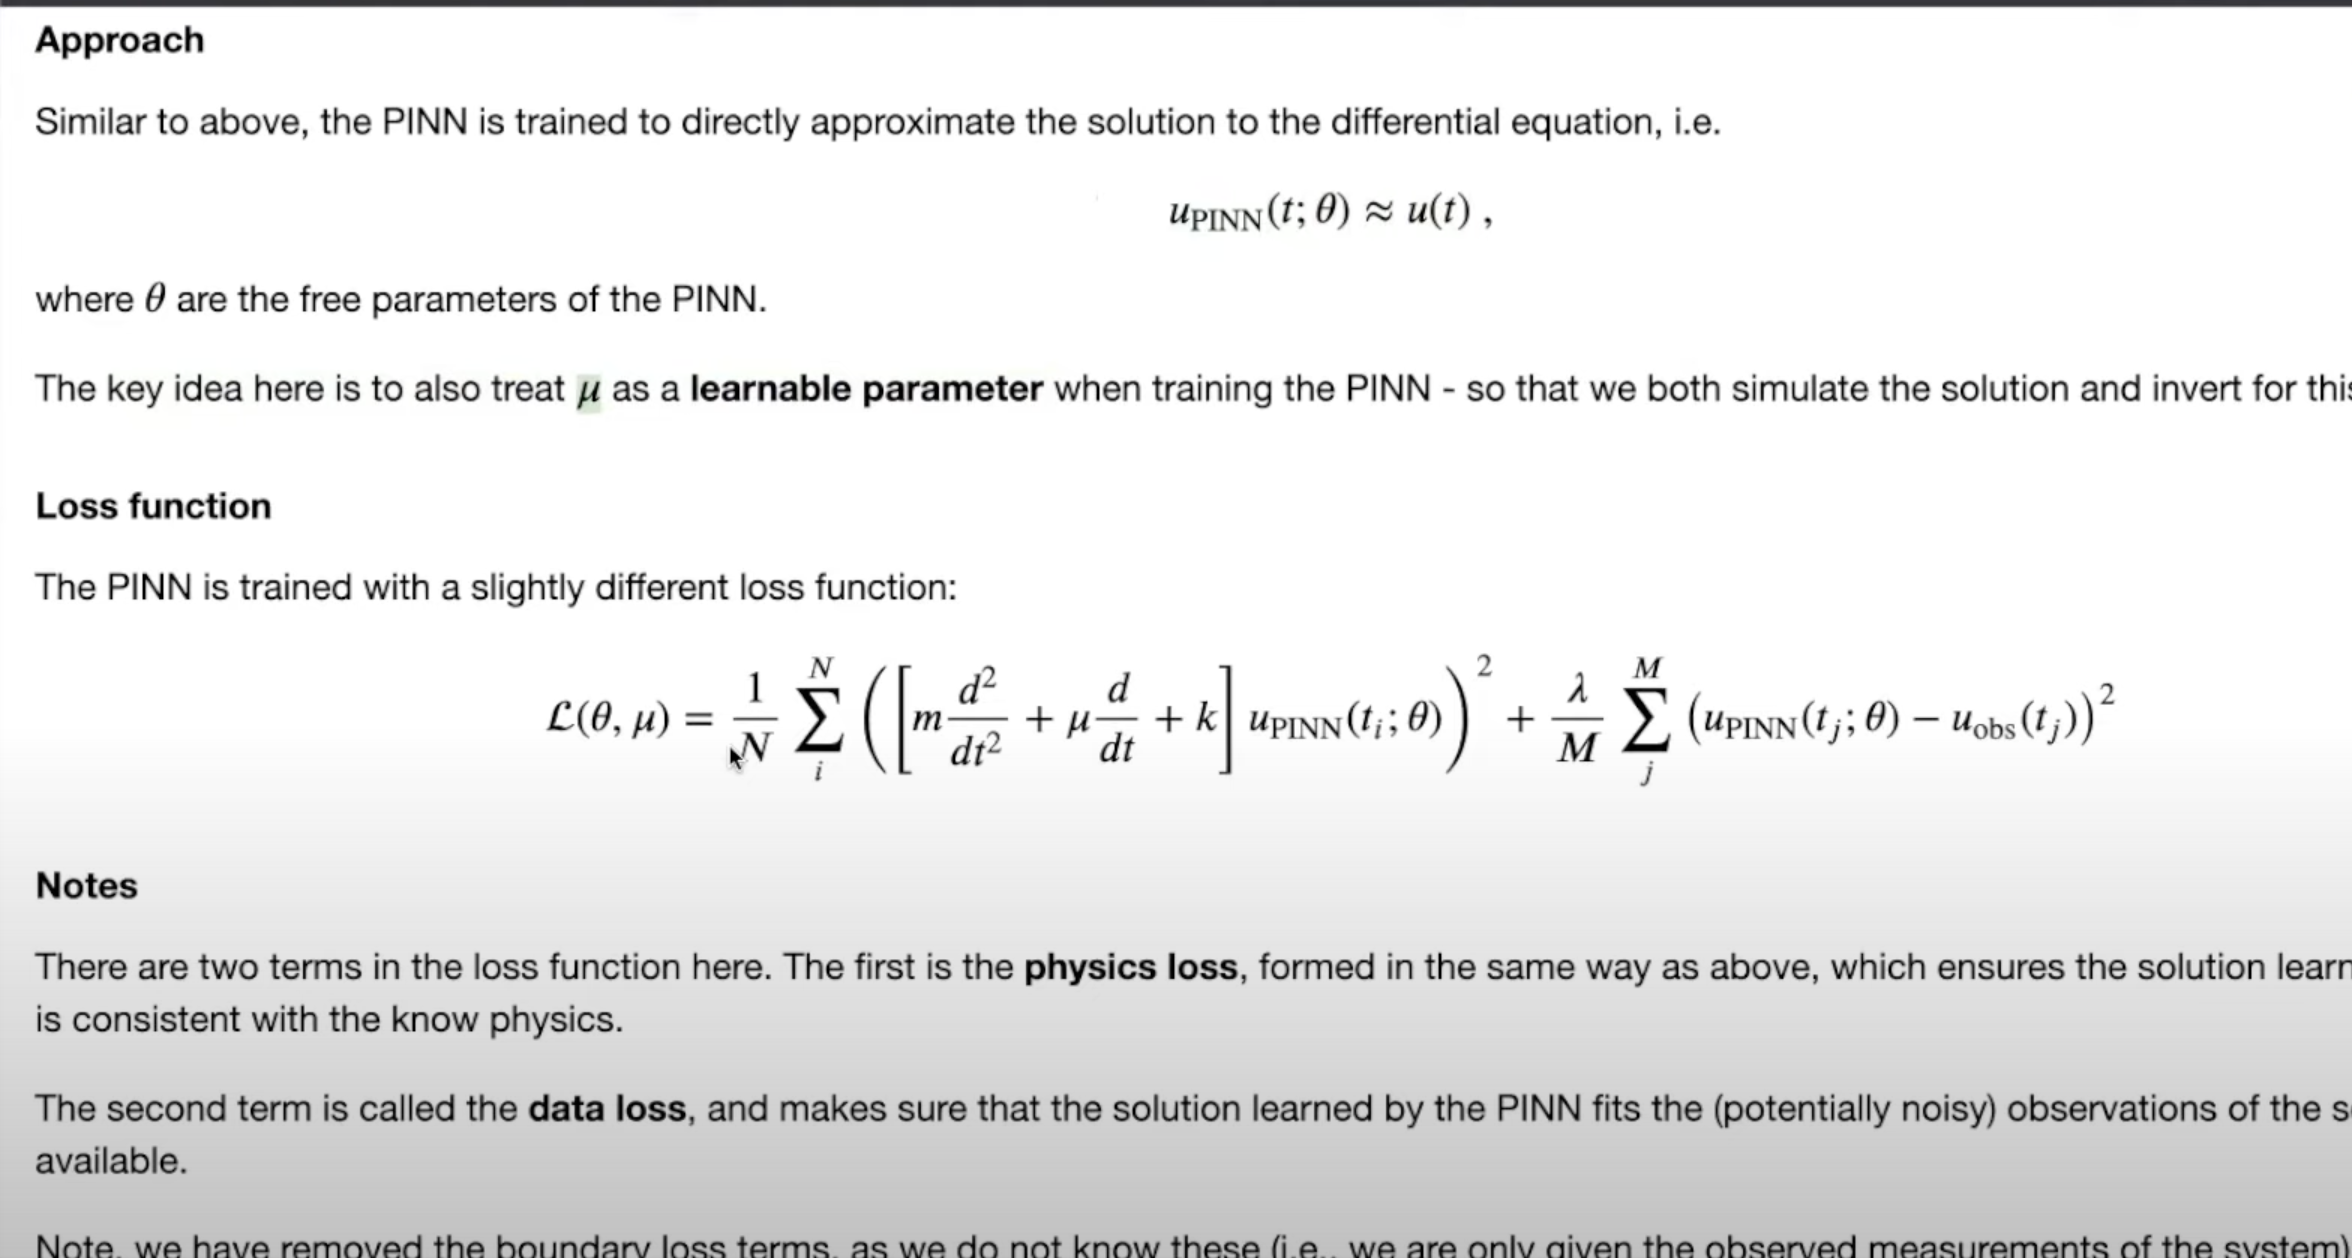

In [6]:
# Load the image
image_path = '/Users/krushna/Desktop/Screenshot 2024-03-27 at 4.46.40 PM.png'  # Provide the path to your image file
image = Image.open(image_path)

# Display the image
display(image)

True value of mu: 4


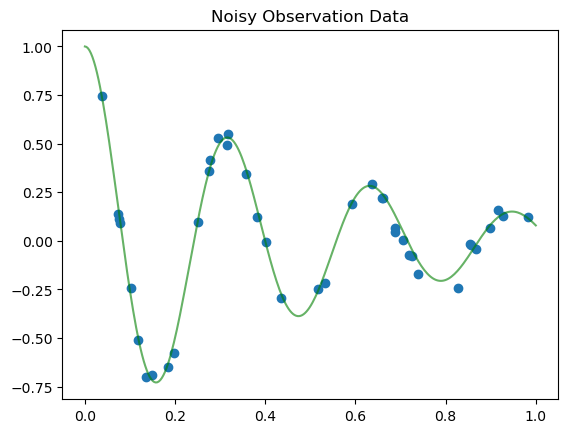

In [9]:
torch.manual_seed(123)
d,wo = 2,20

print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = excat_solution(d,wo,t_obs) + 0.04*torch.randn_like(t_obs)


plt.figure()
plt.title("Noisy Observation Data")
plt.scatter(t_obs[:,0] , u_obs[:,0])
t_test , u_exact = torch.linspace(0,1,300).view(-1,1), excat_solution(d,wo,t_test)
plt.plot(t_test[:,0] , u_exact[:,0], label = "Exact Solution", color = "green", alpha = 0.6)
plt.show()

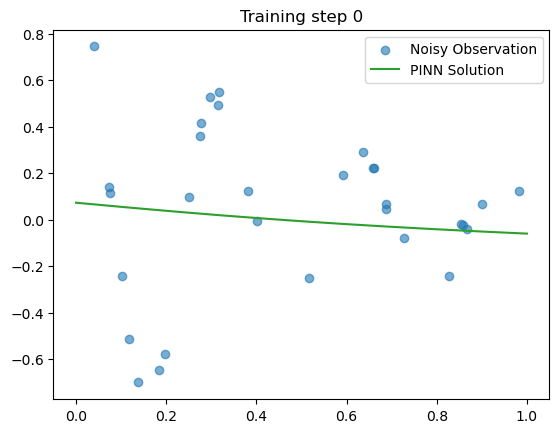

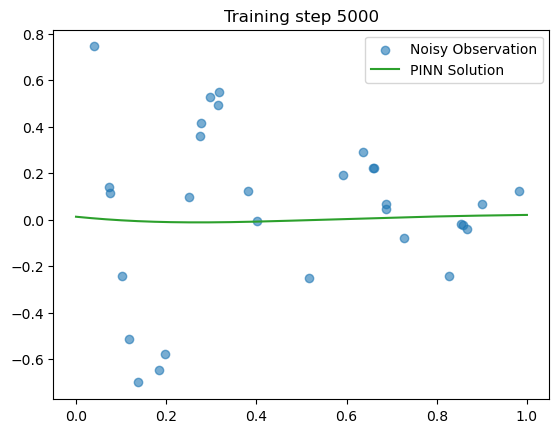

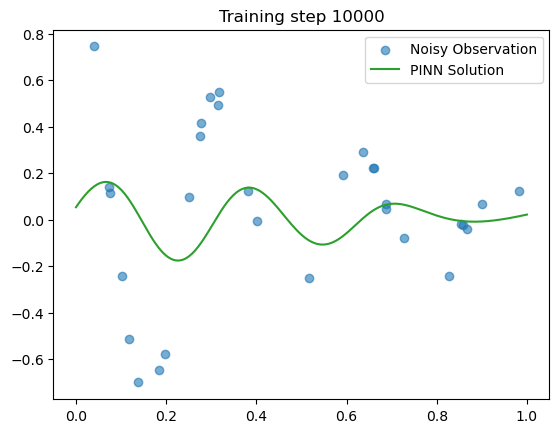

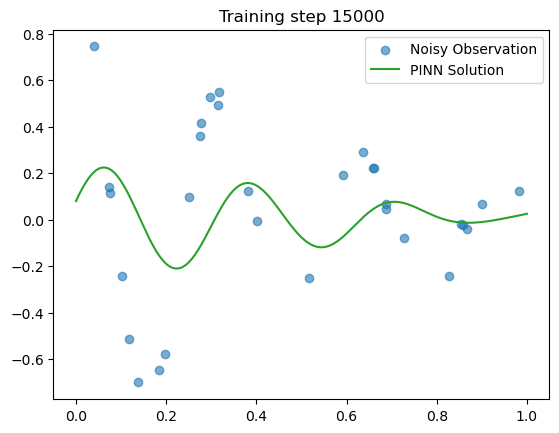

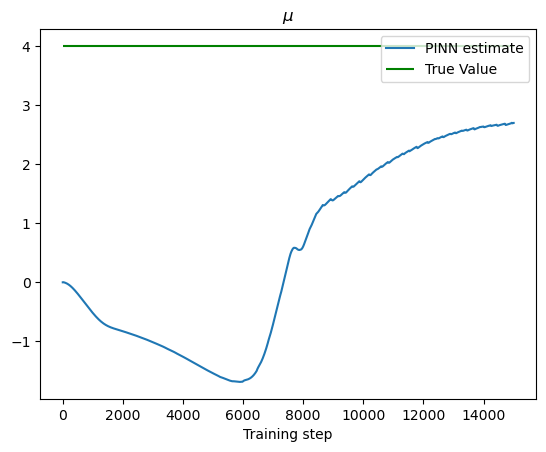

In [17]:
torch.manual_seed(123)

# define neural network to train the model
pinn = FCN(1,1,32,3)

# define physical loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the pinn
d , wo= 2,20
_ ,k = 2*d , wo**2
# treate mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1,requires_grad =True))
mus=[]
#add mu
optimiser = torch.optim.Adam(list(pinn.parameters() )+[mu], lr = 1e-3)

u_obs = u_obs[:30]
t_obs = t_obs[:30]
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the Pinn loss function using hyperparameters
    lambda1 = 1e4
    
    #compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u,t_physics,torch.ones_like(u) , create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt,t_physics,torch.ones_like(u) , create_graph = True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # data loss
    u = pinn(t_physics)
    loss2 = torch.mean((u-u_obs)**2)
    
    #backpropogate joint loss, take optimiser step
    loss = loss1+lambda1*loss2
    loss.backward()
    optimiser.step()
    
    mus.append(mu.item())
    
    if i %5000 ==0:
        #print(u.abs().mean().item(), dudt.abs().mean().item , d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.scatter(t_obs[:,0], u_obs[:,0], label = "Noisy Observation", alpha =0.6)
        plt.plot(t_test[:,0] , u[:,0], label = "PINN Solution", color = "tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

plt.figure()
plt.title("$\mu$")
plt.plot(mus, label= "PINN estimate")
plt.hlines(2*d, 0, len(mus), label= "True Value", color = "green")
plt.legend()
plt.xlabel("Training step")
plt.show()